In [ ]:
"""
Test Set Evaluation for Stance Classifier

Evaluates the best saved model on the test set and generates:
- Macro-averaged F1 (primary metric for skewed distribution)
- Per-class precision/recall/F1 and support counts
- Confusion matrix
- Error analysis

For report generation.
"""

'\nTest Set Evaluation for Stance Classifier\n\nEvaluates the best saved model on the test set and generates:\n- Macro-averaged F1 (primary metric for skewed distribution)\n- Per-class precision/recall/F1 and support counts\n- Confusion matrix\n- Error analysis\n\nFor report generation.\n'

In [ ]:
# Imports and Setup

import os
import json
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import PeftModel
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tqdm.auto import tqdm

from data_loader import load_dataset, format_input_with_context, LABEL_TO_ID, ID_TO_LABEL

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Device: {DEVICE}")

CHECKPOINT_DIR = "./results/classifier/best_model"
RESULTS_DIR = "./results/evaluation"

/Users/Subspace_Explorer/Documents/Programming/NLP_cswk/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: mps


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/Subspace_Explorer/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Load Model

def load_model():
    """Load the saved model checkpoint."""
    config_path = os.path.join(CHECKPOINT_DIR, "adapter_config.json")
    with open(config_path, 'r') as f:
        adapter_config = json.load(f)
    
    base_model_name = adapter_config['base_model_name_or_path']
    print(f"Base model: {base_model_name}")
    print(f"LoRA rank: {adapter_config['r']}, alpha: {adapter_config['lora_alpha']}")
    
    tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT_DIR, use_fast=False)
    
    base_model = AutoModelForSequenceClassification.from_pretrained(
        base_model_name,
        num_labels=4,
        problem_type="single_label_classification",
        use_safetensors=True,  # Required for torch < 2.6
    )
    
    model = PeftModel.from_pretrained(base_model, CHECKPOINT_DIR, safe_serialization=True)
    model = model.to(DEVICE)
    model.eval()
    
    print(f"✅ Model loaded on {DEVICE}")
    return model, tokenizer

model, tokenizer = load_model()

Base model: vinai/bertweet-large
LoRA rank: 16, alpha: 64


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded on mps


In [ ]:
# Load Test Data

train_df, dev_df, test_df = load_dataset()
full_df = pd.concat([train_df, dev_df, test_df], ignore_index=True)

print(f"Test set size: {len(test_df)}")
print(f"\nClass distribution:")
for label, count in test_df['label_text'].value_counts().items():
    print(f"  {label}: {count} ({count/len(test_df)*100:.1f}%)")

Loading cached data from saved_data/datasets.pkl...
Test set size: 1049

Class distribution:
  comment: 778 (74.2%)
  query: 106 (10.1%)
  support: 94 (9.0%)
  deny: 71 (6.8%)


In [ ]:
# Format Inputs and Run Inference

def predict_batch(model, tokenizer, texts, max_length=256, batch_size=16):
    """Batch prediction for efficiency."""
    all_preds = []
    all_probs = []
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        
        encoding = tokenizer(
            batch_texts,
            truncation=True,
            max_length=max_length,
            padding=True,
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].to(DEVICE)
        attention_mask = encoding['attention_mask'].to(DEVICE)
        
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.softmax(outputs.logits, dim=1)
            preds = torch.argmax(outputs.logits, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_preds), np.array(all_probs)


# Format inputs
print("Formatting inputs...")
texts = []
for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Formatting"):
    texts.append(format_input_with_context(row, full_df, use_features=True, use_context=True))

# Run inference
print("Running inference...")
predictions, probabilities = predict_batch(model, tokenizer, texts)
labels = test_df['label'].values

Formatting inputs...


Formatting: 100%|██████████| 1049/1049 [00:01<00:00, 758.71it/s]


Running inference...


In [ ]:
# Primary Metrics

class_names = list(LABEL_TO_ID.keys())

macro_f1 = f1_score(labels, predictions, average='macro')
weighted_f1 = f1_score(labels, predictions, average='weighted')

print("=" * 60)
print("PRIMARY METRICS")
print("=" * 60)
print(f"\n📊 Macro F1 (primary): {macro_f1:.4f}")
print(f"   Weighted F1:        {weighted_f1:.4f}")

PRIMARY METRICS

📊 Macro F1 (primary): 0.6052
   Weighted F1:        0.7699


In [ ]:
# Per-Class Metrics (Precision, Recall, F1, Support)

print("\n" + "=" * 60)
print("PER-CLASS METRICS")
print("=" * 60)

report = classification_report(labels, predictions, target_names=class_names, output_dict=True)
print(classification_report(labels, predictions, target_names=class_names))

# Save to CSV
os.makedirs(RESULTS_DIR, exist_ok=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(os.path.join(RESULTS_DIR, "classification_report.csv"))
print(f"Saved: {RESULTS_DIR}/classification_report.csv")


PER-CLASS METRICS
              precision    recall  f1-score   support

     support       0.46      0.43      0.44        94
        deny       0.32      0.51      0.39        71
       query       0.67      0.83      0.74       106
     comment       0.88      0.81      0.85       778

    accuracy                           0.76      1049
   macro avg       0.58      0.64      0.61      1049
weighted avg       0.79      0.76      0.77      1049

Saved: ./results/evaluation/classification_report.csv


In [ ]:
# Confusion Matrix

print("\n" + "=" * 60)
print("CONFUSION MATRIX")
print("=" * 60)

cm = confusion_matrix(labels, predictions)
cm_df = pd.DataFrame(cm, 
                     index=[f"True:{l}" for l in class_names],
                     columns=[f"Pred:{l}" for l in class_names])
print(cm_df)

# Save CSV
cm_df.to_csv(os.path.join(RESULTS_DIR, "confusion_matrix.csv"))


CONFUSION MATRIX
              Pred:support  Pred:deny  Pred:query  Pred:comment
True:support            40         13           4            37
True:deny                3         36           1            31
True:query               0          3          88            15
True:comment            44         61          39           634


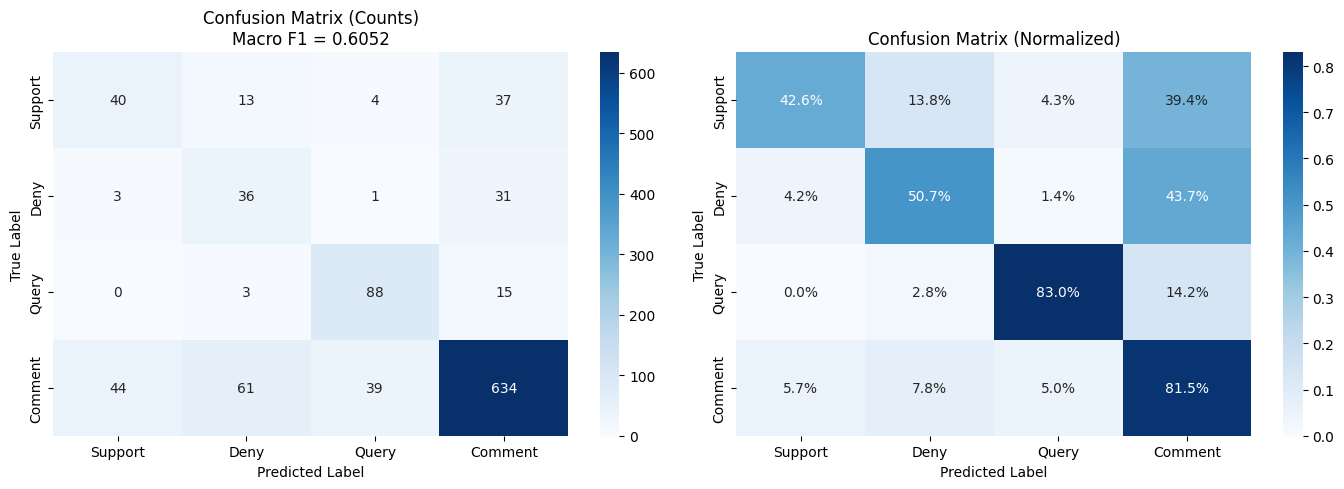

Saved: ./results/evaluation/confusion_matrix.png


In [ ]:
# Confusion Matrix Visualization

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=[l.capitalize() for l in class_names],
            yticklabels=[l.capitalize() for l in class_names])
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title(f'Confusion Matrix (Counts)\nMacro F1 = {macro_f1:.4f}')

# Normalized
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.1%', cmap='Blues', ax=axes[1],
            xticklabels=[l.capitalize() for l in class_names],
            yticklabels=[l.capitalize() for l in class_names])
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_title(f'Confusion Matrix (Normalized)')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "confusion_matrix.png"), dpi=150)
plt.show()

print(f"Saved: {RESULTS_DIR}/confusion_matrix.png")

In [ ]:
# Per-Class Error Analysis

print("\n" + "=" * 60)
print("PER-CLASS ERROR ANALYSIS")
print("=" * 60)

test_df_results = test_df.copy()
test_df_results['predicted'] = [ID_TO_LABEL[p] for p in predictions]
test_df_results['correct'] = test_df_results['predicted'] == test_df_results['label_text']
test_df_results['confidence'] = [probabilities[i, predictions[i]] for i in range(len(predictions))]

for label_id, label_name in ID_TO_LABEL.items():
    class_df = test_df_results[test_df_results['label'] == label_id]
    
    if len(class_df) == 0:
        continue
    
    correct = class_df['correct'].sum()
    total = len(class_df)
    avg_conf = class_df['confidence'].mean()
    
    print(f"\n{label_name.upper()} (support={total}):")
    print(f"  Accuracy: {correct}/{total} ({correct/total*100:.1f}%)")
    print(f"  Avg Confidence: {avg_conf:.3f}")
    
    # Misclassification breakdown
    errors = class_df[~class_df['correct']]
    if len(errors) > 0:
        error_dist = errors['predicted'].value_counts()
        print(f"  Misclassified as:")
        for pred_label, count in error_dist.items():
            print(f"    → {pred_label}: {count} ({count/len(errors)*100:.1f}%)")


PER-CLASS ERROR ANALYSIS

SUPPORT (support=94):
  Accuracy: 40/94 (42.6%)
  Avg Confidence: 0.722
  Misclassified as:
    → comment: 37 (68.5%)
    → deny: 13 (24.1%)
    → query: 4 (7.4%)

DENY (support=71):
  Accuracy: 36/71 (50.7%)
  Avg Confidence: 0.677
  Misclassified as:
    → comment: 31 (88.6%)
    → support: 3 (8.6%)
    → query: 1 (2.9%)

QUERY (support=106):
  Accuracy: 88/106 (83.0%)
  Avg Confidence: 0.812
  Misclassified as:
    → comment: 15 (83.3%)
    → deny: 3 (16.7%)

COMMENT (support=778):
  Accuracy: 634/778 (81.5%)
  Avg Confidence: 0.670
  Misclassified as:
    → deny: 61 (42.4%)
    → support: 44 (30.6%)
    → query: 39 (27.1%)


In [ ]:
# Save Results

# Save predictions
results_df = test_df_results[['tweet_id', 'text', 'label_text', 'predicted', 'correct', 'confidence']].copy()
results_df.to_csv(os.path.join(RESULTS_DIR, "test_predictions.csv"), index=False)
print(f"Saved: {RESULTS_DIR}/test_predictions.csv")

# Summary JSON
summary = {
    'macro_f1': float(macro_f1),
    'weighted_f1': float(weighted_f1),
    'test_size': len(test_df),
    'per_class': {
        class_name: {
            'precision': report[class_name]['precision'],
            'recall': report[class_name]['recall'],
            'f1': report[class_name]['f1-score'],
            'support': int(report[class_name]['support']),
        }
        for class_name in class_names
    },
    'confusion_matrix': cm.tolist(),
}

with open(os.path.join(RESULTS_DIR, "summary.json"), 'w') as f:
    json.dump(summary, f, indent=2)
print(f"Saved: {RESULTS_DIR}/summary.json")

Saved: ./results/evaluation/test_predictions.csv
Saved: ./results/evaluation/summary.json


In [ ]:
# Final Summary

print("\n" + "=" * 60)
print("✅ TEST SET EVALUATION COMPLETE")
print("=" * 60)
print(f"\n📊 Final Test Macro F1: {macro_f1:.4f}")
print(f"\nResults saved to: {RESULTS_DIR}/")
print(f"  - classification_report.csv")
print(f"  - confusion_matrix.csv")
print(f"  - confusion_matrix.png")
print(f"  - test_predictions.csv")
print(f"  - summary.json")


✅ TEST SET EVALUATION COMPLETE

📊 Final Test Macro F1: 0.6052

Results saved to: ./results/evaluation/
  - classification_report.csv
  - confusion_matrix.csv
  - confusion_matrix.png
  - test_predictions.csv
  - summary.json
